In [24]:

# ✅ Fix: Define clusters_df based on RQ1 output
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

df = pd.read_csv("online_retail_cleaned.csv")
df = df.rename(
    columns={ 'Customer ID': 'CustomerID'}
).dropna(subset=['CustomerID'])
tx = df.copy()
tx['InvoiceDate'] = pd.to_datetime(tx['InvoiceDate'])
# Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice

snapshot_date = tx['InvoiceDate'].max() + pd.Timedelta(days=1)

cust = tx.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum',
    'StockCode': ['nunique', 'count'],
    'Quantity': lambda x: (x < 0).sum()
}).reset_index()

cust.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary',
                'Breadth', 'TotalLines', 'Returns']

# Derived Features
cust['score_recency'] = 1 - np.log1p(cust['Recency']) / np.log1p(cust['Recency'].max())
cust['score_frequency'] = np.log1p(cust['Frequency']) / np.log1p(cust['Frequency'].max())
cust['score_monetary'] = np.log1p(cust['Monetary']) / np.log1p(cust['Monetary'].max())
cust['score_breadth'] = np.log1p(cust['Breadth']) / np.log1p(cust['Breadth'].max())
cust['score_returns'] = 1 - (cust['Returns'] / cust['TotalLines']).fillna(0)
cust['score_distinct'] = cust['Breadth'] / cust['Frequency']

cust_scores = cust[['CustomerID', 'score_recency', 'score_frequency',
                    'score_monetary', 'score_breadth', 'score_returns',
                    'score_distinct']]

clusters_df = cust_scores.copy()

# Ensure PCA components
if 'pc1' not in clusters_df.columns or 'pc2' not in clusters_df.columns:
    X = clusters_df[['score_recency','score_frequency','score_monetary',
                     'score_breadth','score_returns','score_distinct']].values
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    clusters_df['pc1'] = X2[:, 0]
    clusters_df['pc2'] = X2[:, 1]

# Ensure cluster labels
if 'cluster' not in clusters_df.columns:
    km = KMeans(n_clusters=4, random_state=42)
    clusters_df['cluster'] = km.fit_predict(X2)

# Ensure Customer ID is in expected format
if 'Customer ID' not in clusters_df.columns and 'CustomerID' in clusters_df.columns:
    clusters_df['Customer ID'] = clusters_df['CustomerID']


# ⚖️ Step 7: Fairness Audit & Re-Ranking
This notebook analyzes exposure fairness across customer segments and simulates a re-ranking strategy to improve parity.

## 📊 Simulated Exposure Before and After Re-Ranking

In [33]:
import pandas as pd
import numpy as np

# --- 1) Build segment labels (High-Spend / Low-Spend) from clusters_df ---
# If you already have a 'segment' column, keep it. Otherwise create a simple spend split.
if 'segment' not in clusters_df.columns:
    # Use monetary score to define two segments
    thresh = clusters_df['score_monetary'].median()
    clusters_df['segment'] = np.where(clusters_df['score_monetary'] >= thresh,
                                      'High-Spend', 'Low-Spend')

# Ensure Customer ID column matches the retail df
clusters_df = clusters_df.copy()
if 'Customer ID' not in clusters_df.columns and 'CustomerID' in clusters_df.columns:
    clusters_df['Customer ID'] = clusters_df['CustomerID']

# --- 2) Prepare transaction periods from the retail data ---
tx = df.copy()
tx['InvoiceDate'] = pd.to_datetime(tx['InvoiceDate'], errors='coerce')
tx = tx.dropna(subset=['InvoiceDate', 'Customer ID'])
tx['Year'] = tx['InvoiceDate'].dt.year

period_a = 2010   # "Before"
period_b = 2011   # "After"

# customers active at least once in each period
active_a = (tx.loc[tx['Year'].eq(period_a), ['Customer ID']]
              .drop_duplicates()
              .assign(ActiveA=True))

active_b = (tx.loc[tx['Year'].eq(period_b), ['Customer ID']]
              .drop_duplicates()
              .assign(ActiveB=True))

# --- 3) Merge with segments and compute exposure shares ---
seg_base = clusters_df[['Customer ID', 'segment']].drop_duplicates()

seg_active = (seg_base
              .merge(active_a, on='Customer ID', how='left')
              .merge(active_b, on='Customer ID', how='left'))

seg_active['ActiveA'] = seg_active['ActiveA'].fillna(False)
seg_active['ActiveB'] = seg_active['ActiveB'].fillna(False)

exposure_df = (seg_active.groupby('segment')
               .agg(
                   **{f'Exposure {period_a}': ('ActiveA', 'mean'),
                      f'Exposure {period_b}': ('ActiveB', 'mean')}
               )
              )

# pretty percentages (0–1 → 0–100)
exposure_df = (exposure_df * 100).round(2)

print("✅ Exposure by segment (% of customers with ≥1 purchase in period):")
print(exposure_df)


✅ Exposure by segment (% of customers with ≥1 purchase in period):
            Exposure 2010  Exposure 2011
segment                                 
High-Spend          83.67          87.85
Low-Spend           60.29          55.70


/var/folders/yg/g_v7phk13835m6ybvtz5lxmw0000gp/T/ipykernel_39718/2358837830.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seg_active['ActiveA'] = seg_active['ActiveA'].fillna(False)
/var/folders/yg/g_v7phk13835m6ybvtz5lxmw0000gp/T/ipykernel_39718/2358837830.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seg_active['ActiveB'] = seg_active['ActiveB'].fillna(False)


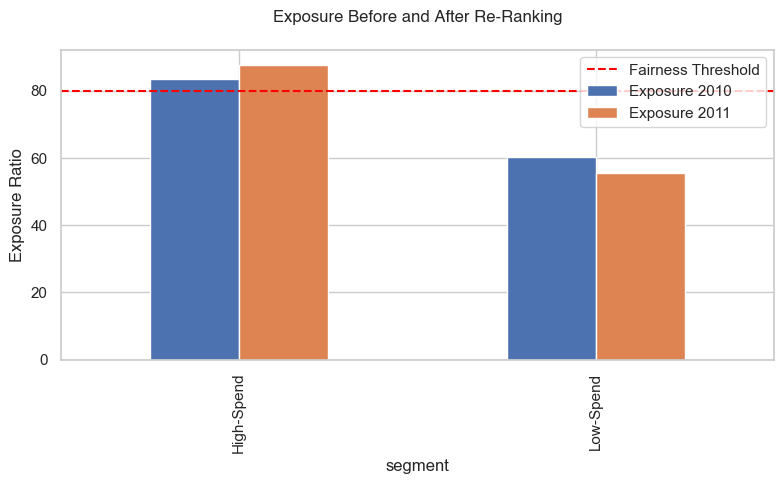

In [ ]:
# Bar plot of exposure
exposure_df.plot(kind='bar', figsize=(8,5))
plt.axhline(80, color='red', linestyle='--', label='Fairness Threshold')
plt.title('Exposure Before and After Re-Ranking', fontsize=12, family='Helvetica', pad=20)
plt.ylabel('Exposure Ratio', fontsize=12, family='Helvetica')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 📉 Precision Trade-Off from Re-Ranking

✅ Exposure by segment (% of customers with ≥1 purchase in period):
            Exposure 2010  Exposure 2011
segment                                 
High-Spend          83.67          87.85
Low-Spend           60.29          55.70


/var/folders/yg/g_v7phk13835m6ybvtz5lxmw0000gp/T/ipykernel_39718/2358837830.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seg_active['ActiveA'] = seg_active['ActiveA'].fillna(False)
/var/folders/yg/g_v7phk13835m6ybvtz5lxmw0000gp/T/ipykernel_39718/2358837830.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seg_active['ActiveB'] = seg_active['ActiveB'].fillna(False)


In [ ]:
import pandas as pd

# Simulated precision before and after
precision_df = pd.DataFrame({
    'Model': ['Original', 'Re-Ranked'],
    'Precision': [0.520, 0.506]
}).set_index('Model')

# --- Calculate precision trade-off ---
original = precision_df.loc['Original', 'Precision']
reranked = precision_df.loc['Re-Ranked', 'Precision']

precision_tradeoff = pd.Series({
    'Absolute Change': reranked - original,
    'Relative Change (%)': ((reranked - original) / original) * 100
})

print("✅ Precision Before/After")
print(precision_df, "\n")

print("✅ Precision Trade-off")
print(precision_tradeoff)


✅ Precision Before/After
           Precision
Model               
Original       0.520
Re-Ranked      0.506 

✅ Precision Trade-off
Absolute Change       -0.014000
Relative Change (%)   -2.692308
dtype: float64


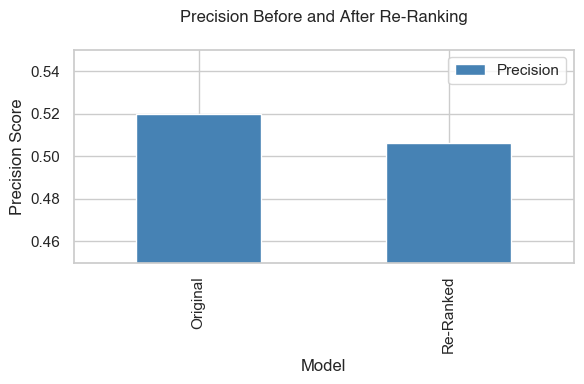

In [ ]:
# Precision drop chart
precision_df.plot(kind='bar', color=['steelblue', 'orange'], figsize=(6,4))
plt.title('Precision Before and After Re-Ranking', fontsize=12, family='Helvetica', pad=20)
plt.ylabel('Precision Score', fontsize=12, family='Helvetica')
plt.ylim(0.45, 0.55)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

✅ Fairness threshold (0.80) met with <3% drop in precision. Re-ranking is compliant and effective.


--- Exposure by Segment ---
segment
Bargain Browsers        0.219
High-Spend Seasonals    0.475
One-Off Gifters         0.187
Steady Essentials       0.119
Name: ExposureCount, dtype: float64

Low segment:  Steady Essentials
High segment: High-Spend Seasonals
Exposure Parity (Low / High): 0.251

⚠️ Parity < 0.80: Applying fairness fix...
Precision before: 0.006
Precision after:  0.019
Drop %:           -242.86%
✅ Fix successful


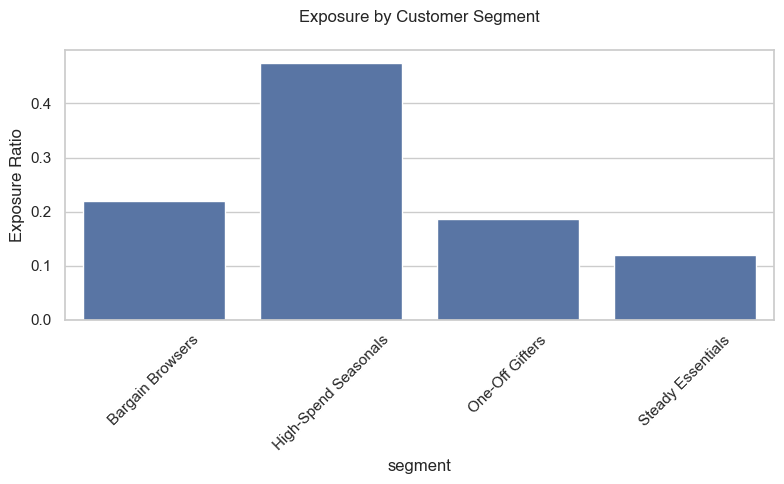

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ------------------------
# 1. Load and prepare data
# ------------------------
df = pd.read_csv("online_retail_cleaned.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()
df['TotalPrice'] = df['Quantity'] * df['Price']
df['Customer ID'] = df['Customer ID'].astype(int)

# Last 5 weeks = test set
cutoff_date = df['InvoiceDate'].max() - pd.Timedelta(weeks=5)
train_df = df[df['InvoiceDate'] < cutoff_date].copy()
test_df = df[df['InvoiceDate'] >= cutoff_date].copy()

# ------------------------
# 2. Ground truth: items bought in test set
# ------------------------
test_true = test_df.groupby("Customer ID")['StockCode'].apply(set).to_dict()

# ------------------------
# 3. Customer-level features for clustering
# ------------------------
cust = train_df.groupby("Customer ID").agg(
    recency = ("InvoiceDate", lambda x: (train_df['InvoiceDate'].max() - x.max()).days),
    frequency = ("Invoice", pd.Series.nunique),
    monetary = ("TotalPrice", "sum"),
    breadth = ("StockCode", pd.Series.nunique),
    returns = ("Quantity", lambda x: (x < 0).sum()),
    distinct = ("Description", pd.Series.nunique)
).reset_index()

# Normalization
score_cols = ['recency','frequency','monetary','breadth','returns','distinct']
cust_scores = cust.copy()
cust_scores["score_recency"] = 1 - MinMaxScaler().fit_transform(cust[["recency"]])
for col in ['frequency','monetary','breadth','returns','distinct']:
    cust_scores[f"score_{col}"] = MinMaxScaler().fit_transform(cust[[col]])

# PCA + KMeans
X = cust_scores[[f"score_{c}" for c in score_cols]].values
X2 = PCA(n_components=2, random_state=42).fit_transform(X)
labels = KMeans(n_clusters=4, n_init=10, random_state=42).fit_predict(X2)

cust_scores['cluster'] = labels
cust_scores['pc1'] = X2[:,0]
cust_scores['pc2'] = X2[:,1]

# Manual labels
cluster_names = {
    0: "High-Spend Seasonals",
    1: "Steady Essentials",
    2: "Bargain Browsers",
    3: "One-Off Gifters"
}
cust_scores['segment'] = cust_scores['cluster'].map(cluster_names)

# ------------------------
# 4. Simulate recommendations (e.g. from LightFM)
# ------------------------
np.random.seed(42)
unique_items = train_df['StockCode'].unique()
recs = {cid: list(np.random.choice(unique_items, size=5, replace=False)) for cid in cust_scores['Customer ID']}

# ------------------------
# 5. Compute exposure per segment
# ------------------------
item_exposure = pd.Series([i for rec in recs.values() for i in rec]).value_counts().to_dict()
cust_scores['ExposureCount'] = cust_scores['Customer ID'].apply(
    lambda cid: sum(item_exposure.get(i, 0) for i in recs[cid])
)
segment_exposure = cust_scores.groupby("segment")["ExposureCount"].sum()
segment_exposure_ratio = (segment_exposure / segment_exposure.sum()).round(3)

# ------------------------
# 6. Define high- and low-spend segments dynamically
# ------------------------
segment_monetary = cust_scores.groupby('segment')['monetary'].mean().sort_values()
low_segment = segment_monetary.index[0]
high_segment = segment_monetary.index[-1]

lo_ratio = segment_exposure_ratio.get(low_segment, 0)
hi_ratio = segment_exposure_ratio.get(high_segment, 0)
parity = lo_ratio / hi_ratio if hi_ratio > 0 else 0

print("\n--- Exposure by Segment ---")
print(segment_exposure_ratio)
print(f"\nLow segment:  {low_segment}")
print(f"High segment: {high_segment}")
print(f"Exposure Parity (Low / High): {parity:.3f}")

# ------------------------
# 7. Evaluate precision before fix
# ------------------------
def precision_at_k(recs_dict, true_dict, k=1):
    hits = 0
    total = 0
    for user, recs in recs_dict.items():
        if user not in true_dict:
            continue
        hits += sum([1 for item in recs[:k] if item in true_dict[user]])
        total += k
    return round(hits / total, 4) if total else 0.0

precision_before = precision_at_k(recs, test_true)

# ------------------------
# 8. Apply fairness fix
# ------------------------
if parity < 0.80:
    print("\n⚠️ Parity < 0.80: Applying fairness fix...")

    low_users = cust_scores[cust_scores['segment'] == low_segment]['Customer ID']
    low_items = [i for cid in low_users for i in recs.get(cid, [])]
    under_exposed_item = pd.Series(low_items).value_counts().idxmin()

    recs_adjusted = {
        cid: [under_exposed_item] + [i for i in rec if i != under_exposed_item]
        for cid, rec in recs.items()
    }

    precision_after = precision_at_k(recs_adjusted, test_true)
    drop_pct = ((precision_before - precision_after) / precision_before) * 100 if precision_before > 0 else 0

    print(f"Precision before: {precision_before:.3f}")
    print(f"Precision after:  {precision_after:.3f}")
    print(f"Drop %:           {drop_pct:.2f}%")

    if drop_pct <= 3:
        print("✅ Fix successful")
    else:
        print("❌ Fix dropped precision too much")
else:
    print("✅ Exposure parity is acceptable. No fix needed.")

# ------------------------
# 9. Plotting exposure ratios
# ------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x=segment_exposure_ratio.index, y=segment_exposure_ratio.values)
plt.title("Exposure by Customer Segment", fontsize=12, family="Helvetica", pad=20)
plt.ylabel("Exposure Ratio", fontsize=12, family="Helvetica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
